In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


**In this problem set, you will explore some simple embedding algorithms, using position-versus-time data gathered from a real driven pendulum. I have posted three data sets on the class webpage; see the PS8 entry on that page for directions (and a clickable link) to these data. In all three runs, the angle was measured every $\Delta t$ seconds using an optical encoder with a resolution of $0.4$ degree. The drive amplitude was fixed; the drive frequency (the bifurcation paramter) was different for each data set.**

**$\Rightarrow$In `data1`, the drive was turned off.**

**$\Rightarrow$In `data2`, the drive is on, with a medium frequency.**

**$\Rightarrow$In `data3`, the drive is on, with the same amplitude but a higher frequency.**

**Each file captures a single trajectory of the driven pendulum. Each line of each file represents a single time-sample of the pendulum's angular position. Each data point looks like this:**

$$ \theta \quad \text{time}$$

**...where time is in seconds and $\theta$ is $\mod 2\pi$. Depending on when I hit the reset button, $\theta$ may contain an offset, so "$\theta = 0$" may not be "vertical." Also, note that the sampling rate was different; `data1` and `data3` were sampled at $\Delta t = 0.001$ seconds and `data2` at $\Delta t = 0.002$ seconds.**

**The time base and thus the sampling interval in the data acquisition channel may not have been quite uniform. Together with the finite precision of the angle sensor, this has two important implications:**

**$\Rightarrow$ Any $\omega$s that you reconstruct using divided differences from the $\theta$ and time data may be innaccurate. This is problem 1.**

**$\Rightarrow$ Nonuniform sampling violates the conditions of the Takens theorem, so any attractors constructed via embeddings of these data are not true diffeomorphic copies of any attractor that may exist in the system... but they're pretty close. We can mitigate this by using embedding intervals that are much larger than the experimental sampling interval (or by interpolation, if we knew exactly how far off our sampling interval was).**

Initial bookkeeping, let's import the data now. Running on my personal computer (i7-4710HQ (2.50GHz 1600MHz 6MB), 16G RAM), `pandas` can easily handle the combined `10M`.

In [2]:
data1 = pd.read_csv('ps8data/data1', names=['angle', '', '', 'time'],
                    sep=' ')[['angle', 'time']]
data2 = pd.read_csv('ps8data/data2', names=['angle', '', '', 'time'],
                    sep=' ')[['angle', 'time']]
data3 = pd.read_csv('ps8data/data3', names=['angle', '', '', 'time'],
                    sep=' ')[['angle', 'time']]

##Problem 1

**Write a program that steps through a data file, constructs values for $\omega$ using divided differences - first-order forward is good enough, but you may use something smarter if you want - and plots the results in state-space form, with $\theta \mod 2\pi$**

**Note that if data are oversampled - that is, if the sampling rate is much faster than the device's dynamics, as is the case in the data that you're working with here - you have to be a little careful about the divided difference formulae. In particular, you're going to need to downsample the data in order to get a sensible plot. The choice of downsampling rate is part of the thinking part of this problem.**

**Apply this program to `data1` and turn in a plot. Since the drive is off, this plot should be a clean spiral, why? Please comment on what it really looks like, as well as on possible causes for this.**

We do have to downsample for the reasons mentioned above. This downsampling rate will be determined by a downsampling parameter.

In [125]:
downsample = 100

Now we can determine our divided differences with our downsampled data. This will give the slope between every downsample multiple point, the $\omega$ of the system.

In [126]:
divided_differences = ((data1['angle'][downsample::downsample].values -
                        data1['angle'][:-downsample:downsample].values) /
                        (data1['time'][downsample::downsample].values -
                        data1['time'][:-downsample:downsample].values))

Finally, we plot. Both the scatter as well as the connected points have been plotted in order to clarify exactly what is happening. This should be a clean spiral since in a real-world, damped pendulum, the pendulum arm will slowly lose momentum and oscillate at smaller and smaller angles.

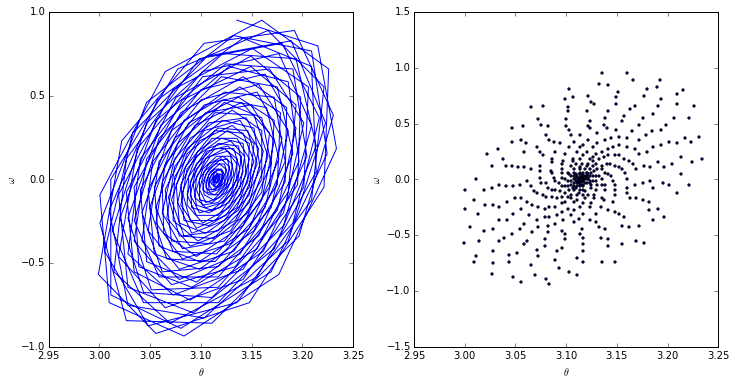

In [566]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
axarr[0].plot(data1['angle'][downsample::downsample].values, divided_differences)
axarr[1].scatter(data1['angle'][downsample::downsample].values, divided_differences, s=5)
axarr[0].set_xlabel(r'$\theta$')
axarr[0].set_ylabel(r'$\omega$')
axarr[1].set_xlabel(r'$\theta$')
axarr[1].set_ylabel(r'$\omega$')
plt.show()

We'll note that this is not a perfect spiral, and in fact it is not only tilted but also a somewhat inconsistent inward spiral. This is probably due to a combination of not having a perfectly constructed pendulum as well as compounded measurement error.

##Problem 2

**Write a program that steps through the data file and embeds the $\theta$ data, producing the corresponding trajectory in reconstruction space. This program should take a time interval $\tau$, a dimension $m$, and indices $j$, $k$ of a pair of axes on which to plot the results. It should produce a list of $m$-vectors (points in reconstruction space) each of whose $i^{th}$ element is $\theta(t + i \tau)$ for $i = 0, \ldots, m - 1$. Finally for each $m$-vector, it should plot the $j^{th}$ element against the $k^{th}$ element, both $\mod 2\pi$.**

In [634]:
def embed_data(data, interval, dimension):
    """
    Returns points to embed
    
    data: pandas dataframe (with evenly spaced points)
    interval: (tau) spacing of "comb" (must go evenly into length)
    dimension: (m) dimension of points
    """
    spacing   = int(interval / (data['time'][1] - data['time'][0]))
    # Establish return array in memory
    embedding = np.zeros((len(data) - spacing * (dimension - 1),
                          dimension))
    for d in range(dimension):
        end             = spacing * (-dimension + d + 1) or None
        start           = d * spacing
        embedding[:, d] = data['angle'][start:end].values
    return embedding

def embedding(data, interval, dimension, j, k):
    """
    Plot embedding of data
    
    returns: figure
    """
    if not ((j < dimension) and (k < dimension)):
        print('j and k must be less than the dimension.')
        print('[{}, {}] >= {}'.format(j, k, dimension))
    points = embed_data(data, interval, dimension)
    fig    = plt.figure(figsize=(50, 50)) # Need to make large in order to see behavior
    ax     = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.scatter(points[:, j], points[:, k], s=1)
    return fig, ax, points

**(a) Run your embedding program on the `data2` set with $\tau = 0.15s$ and $m = 7$. Plot the zeroth elemet of the reconstructed state vector - $\theta (t)$ - on the vertical axis and the second on the horizontal axis ($j, k = 0, 2$). What kind of attractor is this?**

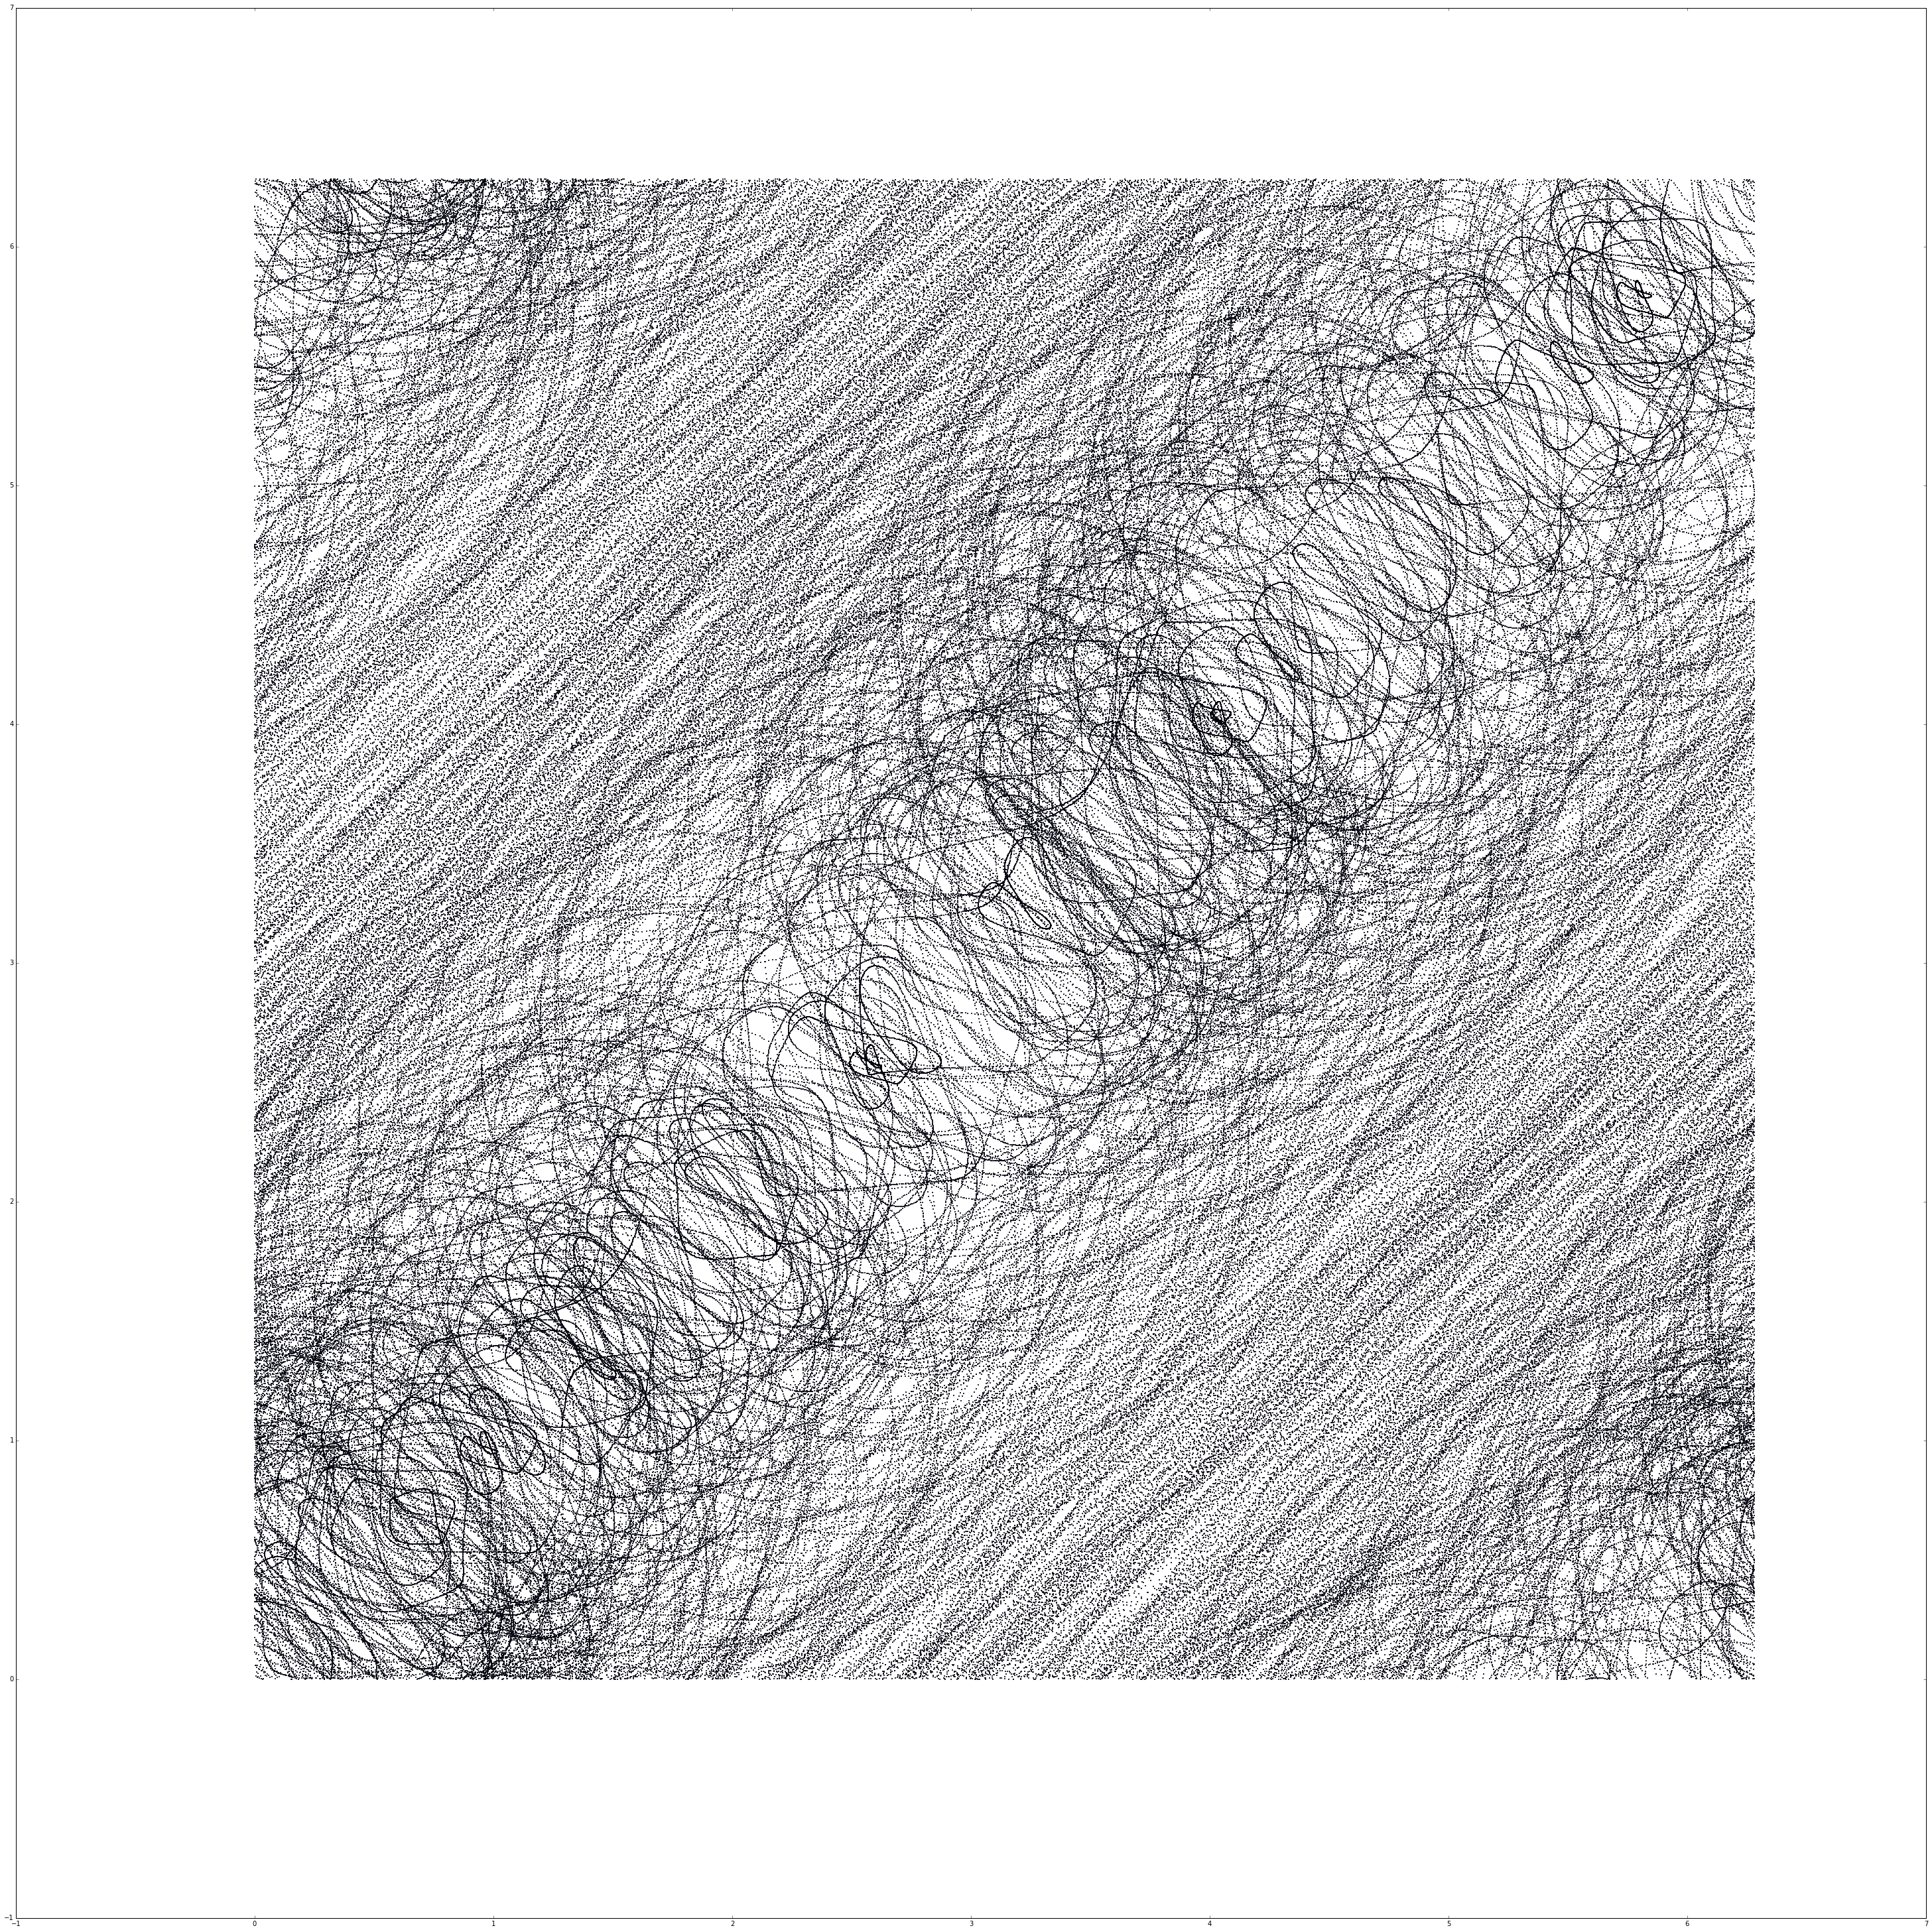

In [632]:
fig, ax, data = embedding(data2, 0.15, 7, 2, 0)
plt.savefig('out.png')
plt.show()

This is a chaotic attractor. Comparing this image to previous analysis with a pendulum we can see that it almost has the structure that we've seen before.

**(b) Now play with the `data3` set: use $m = 7$ and start with $\tau - 0.01s$, then raise $\tau$ to $1.5$, checking at least three intermediate points along the way - e.g., $\tau = 0.01, 0.15, 0.5, 1, 1.5s$. What kind of attractor is this? Describe and explain the effects of the different $\tau$s and turn in one or two interesting plots - of $\theta(t)$ against $\theta(t + 5 \tau)$ this time - that back up your explanations.**

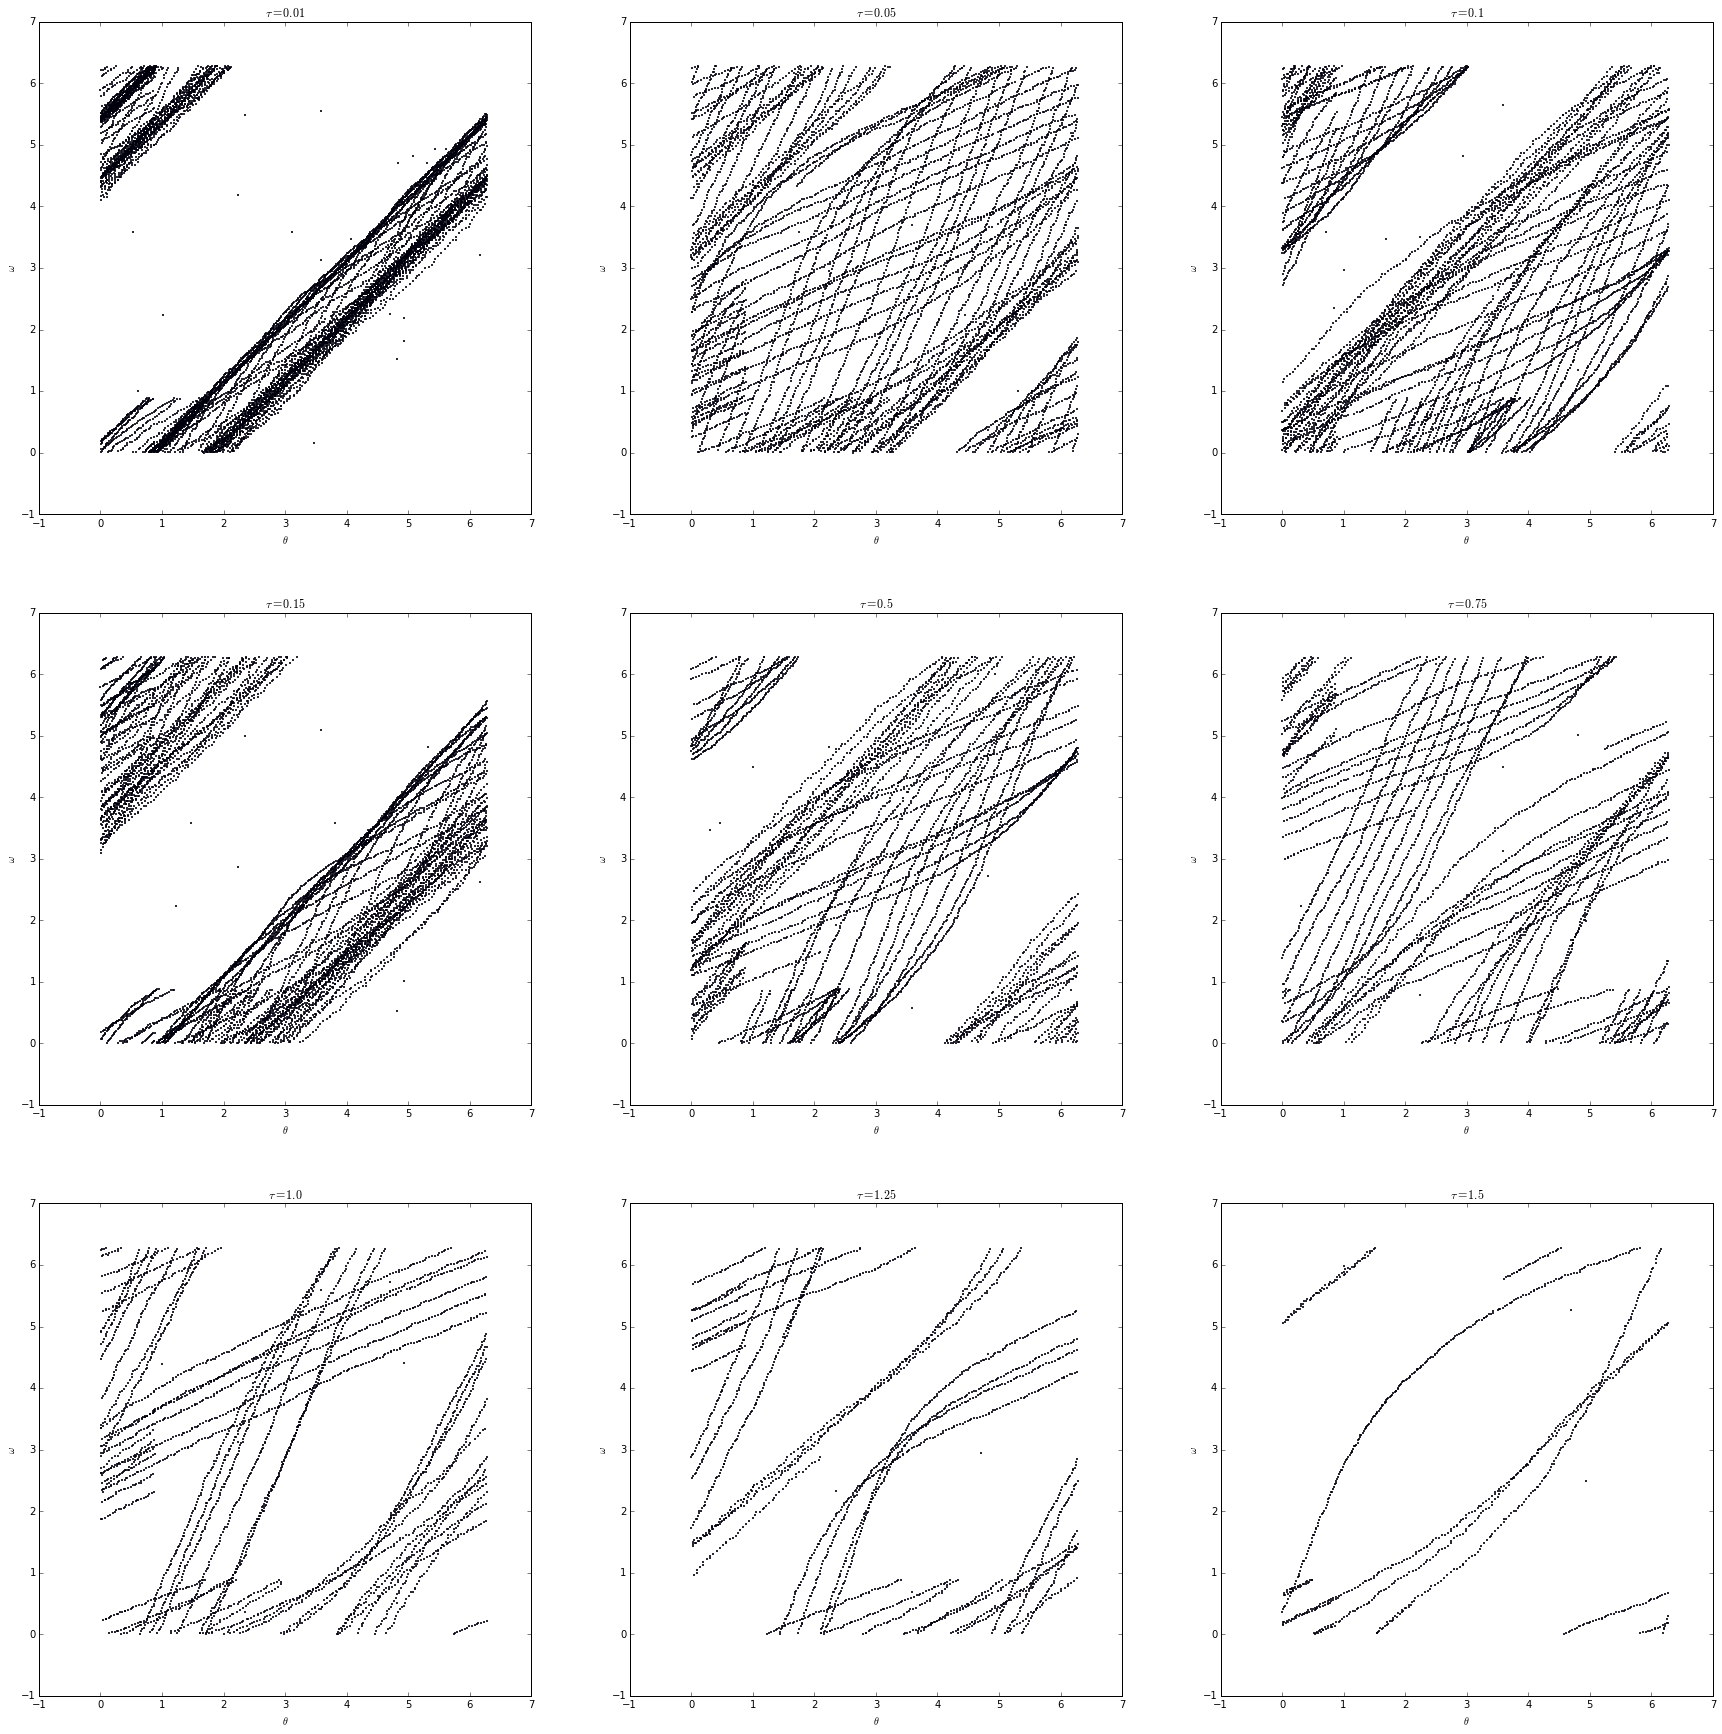

In [635]:
fig, axarr = plt.subplots(3, 3, figsize=(30, 30))
tauarr = [0.01, 0.05, 0.1, 0.15, 0.5, 0.75, 1.0, 1.25, 1.5]
for i in range(9):
    data = embed_data(data3, tauarr[i], 7)
    axarr[int(i / 3), i % 3].scatter(data[:, 0] % 2 * np.pi,
                                     data[:, 5] % 2 * np.pi, s=1)
    axarr[int(i / 3), i % 3].set_xlabel(r'$\theta$')
    axarr[int(i / 3), i % 3].set_ylabel(r'$\omega$')
    axarr[int(i / 3), i % 3].set_title(r'$\tau = {}$'.format(tauarr[i]))
plt.show()

This is a limit cycle. We can tell based on the banding that occurs at the edge of the angled points. In these cases, increasing $\tau$ "spreads" out the line, revealing the structure beneath.

##Problem 3

**(a) In all of these problems, we used $m = 7$ whether or not the drive was on. What requirements does the Takens theorem place on $m$ for a successful embedding of the driven pendulum? What about the undriven pendulum?**

For the pendulum we use the following equation.

$$
P(\theta, \omega, t) = \frac{A \cos(\alpha t)}{ml} - \frac{\beta \omega}{m} - \frac{g \sin(\theta)}{l}
$$

In this system we have three parameters, and by the Takens theorem the number of dimensions must be greater than the number of parameters. This means that $m = 7$ is necessary for the driven pendulum.

On the other hand, for the undriven pendulum the equation becomes

$$
P(\theta, \omega, t) = - \frac{g \sin(\theta)}{l}
$$

and with only two parameters the number of dimensions is only 3.

**(b) What do you think would happen to the reconstructed trajectory - not just your picture, but the full trajectory - in part (b) of problem 2 if you had used $m = 2$ or $m = 25$?**

Let's test this for $m = 2$.

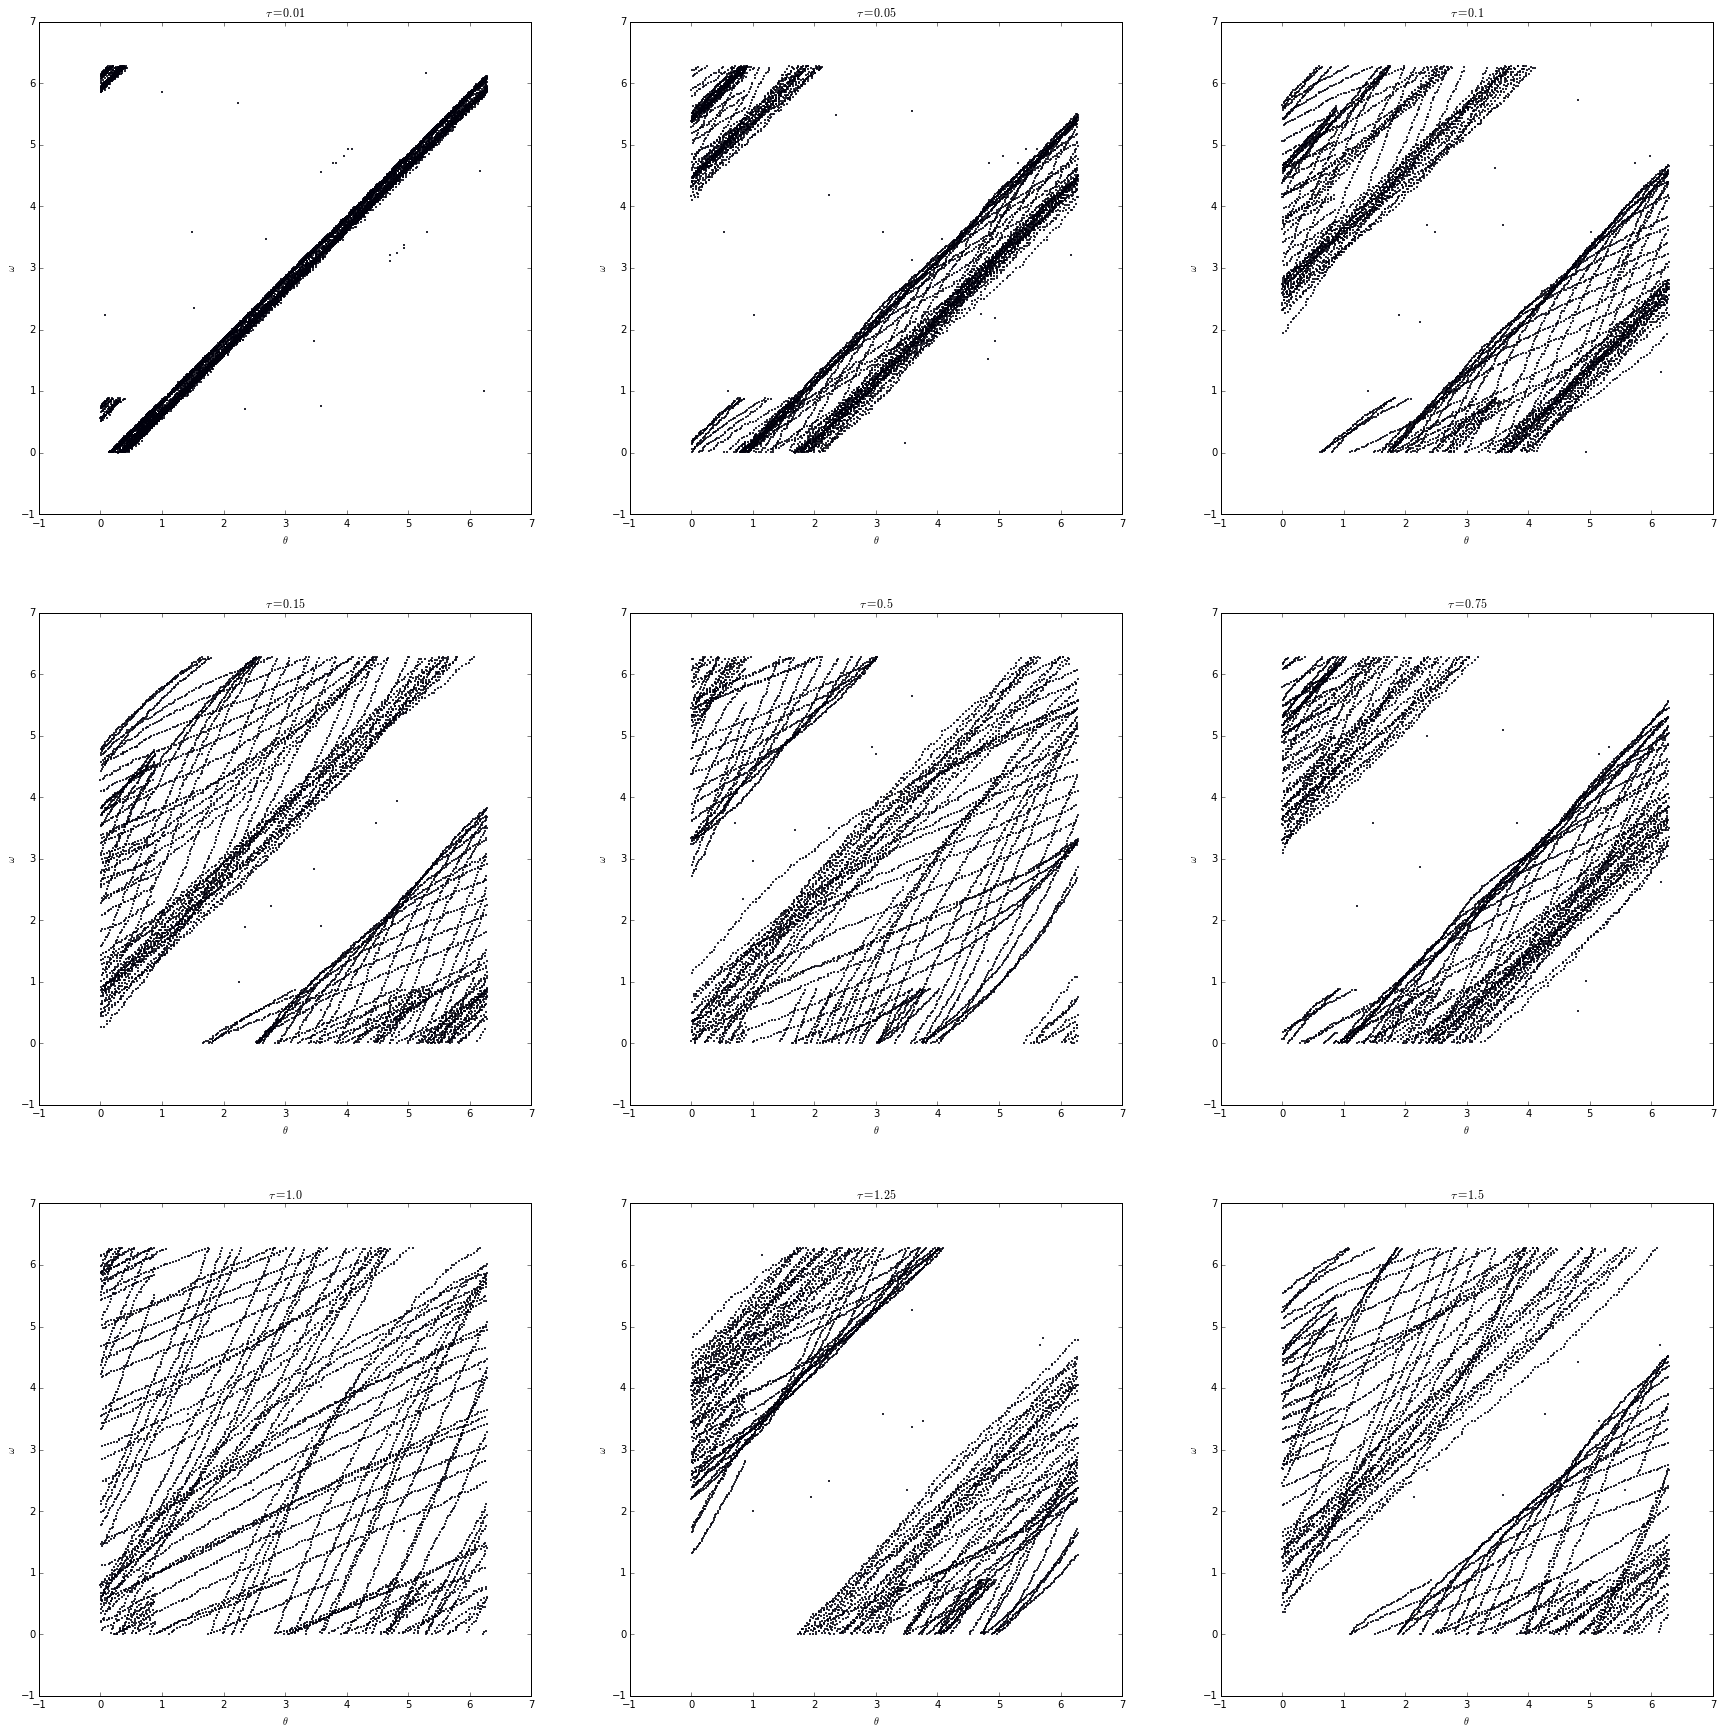

In [637]:
fig, axarr = plt.subplots(3, 3, figsize=(30, 30))
tauarr = [0.01, 0.05, 0.1, 0.15, 0.5, 0.75, 1.0, 1.25, 1.5]
for i in range(9):
    data = embed_data(data3, tauarr[i], 2)
    axarr[int(i / 3), i % 3].scatter(data[:, 0] % 2 * np.pi,
                                     data[:, 1] % 2 * np.pi, s=1)
    axarr[int(i / 3), i % 3].set_xlabel(r'$\theta$')
    axarr[int(i / 3), i % 3].set_ylabel(r'$\omega$')
    axarr[int(i / 3), i % 3].set_title(r'$\tau = {}$'.format(tauarr[i]))
plt.show()

Using what we know about embedding dimensions we can safely say that if the number of dimensions was reduced we would not only lose the diffeomorphic properties of the embedding, but also detail as the plot would be restricted. By embedding in fewer dimensions than necessary we don't allow the embedding enough room to "grow", causing it to be stunted.

On the other hand, by increasing the number of dimensions significantly we face the opposite problem. This causes too much of the information to be spread out on too many dimensions, meaning we lose information because we can only see so much of it at any point. Going to the extreme, if the number of dimensions was equal to the length of the dataset, we would only have one point in $N$-dimensional space, where $N$ is the length of the dataset.

**(c) What do you think would happen to the reconstructed trajectory in part (a) of problem 2 if you had used $\tau = {10}^{-16}$ - which would require much more frequent sampling, obviously - or $\tau = {10}^6$? What would your pictures look like?**

If we were to adjust $\tau$ to either really small or really big we would see some radically different behavior. In the case of it being smaller, the system would be reduced to a single line, as the points that are being plotted are almost identical. This would make the internal structure of the embedded system incredibly obfuscated, as everything would be restricted to such a small area.

On the other hand if the points being plotted were really far apart we would have the opposite problem. The system would be incredibly spread out as the change between each point is fairly drastic. Again, if $\tau$ is large enough we would only be able to plot a couple points and out system wouldn't be a good representation as there just wouldn't be enough data plotted.